In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



import numpy as np
import timeit

# Data Loading

In [9]:
df = pd.read_csv('./Data/artists.csv', sep=",")
print("The number of painting is {}.".format(df.shape[0]))

The number of painting is 50.


In [10]:
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


# Data Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


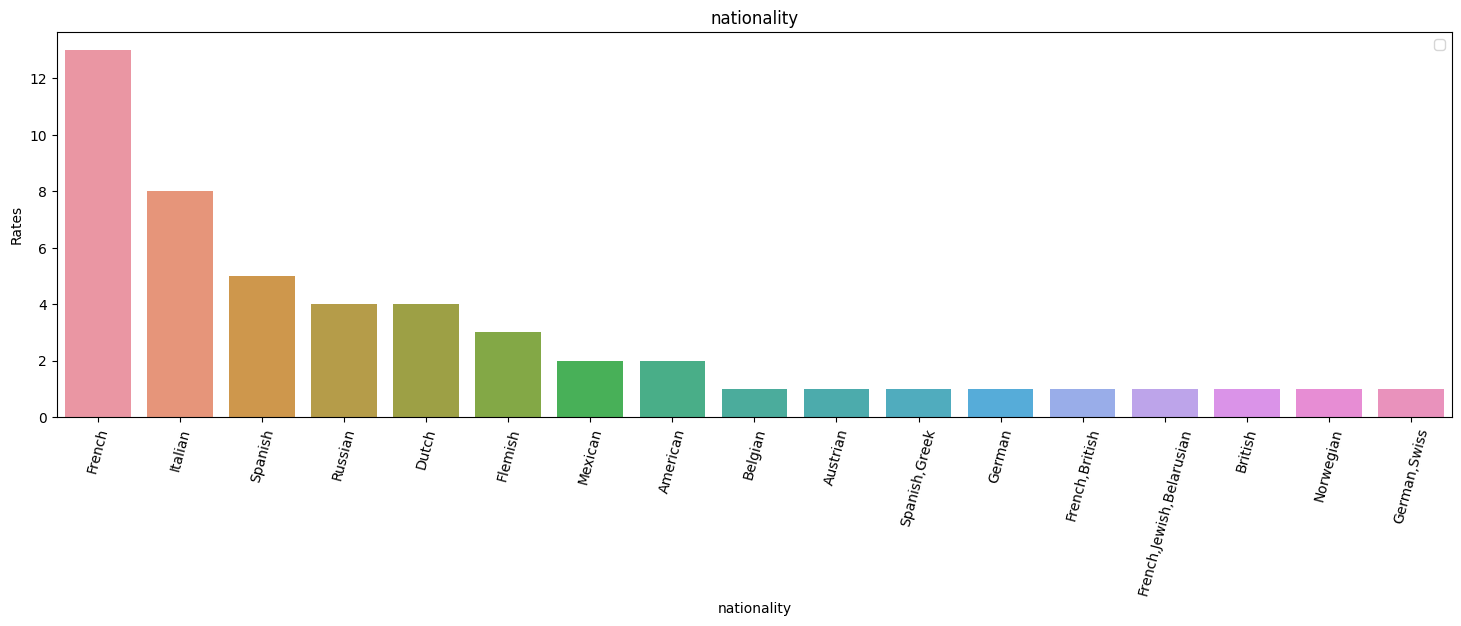

In [11]:
plt.figure(figsize=(18,5))

sns.barplot(x=df['nationality'].value_counts().index,y=df['nationality'].value_counts().values)
plt.title('nationality')
plt.xticks(rotation=75)
plt.ylabel('Rates')
plt.legend(loc=0)
plt.show()